# 多层感知机

> 本文参考：
- 伯禹AI：https://www.boyuai.com/elites/course/cZu18YmweLv10OeV
- 动手学深度学习：http://zh.d2l.ai/
- 动手学深度学习 TF 版：https://trickygo.github.io/Dive-into-DL-TensorFlow2.0

1. 多层感知机的基本知识
2. 使用多层感知机图像分类的从零开始的实现
3. 使用 tensorflow 2.0 的简洁实现

## 多层感知机的基本知识
深度学习主要关注多层模型。在这里，我们将以多层感知机（multilayer perceptron，MLP）为例，介绍多层神经网络的概念。

### 隐藏层
下图展示了一个多层感知机的神经网络图，它含有一个隐藏层，该层中有5个隐藏单元(hidden unit)。输入层不参加计算，所以层数为2.

![Image Name](../img/chapter03/3.8_mlp.svg)

### 表达公式
具体来说，给定一个小批量样本$\boldsymbol{X} \in \mathbb{R}^{n \times d}$，其批量大小为$n$，输入个数为$d$。假设多层感知机只有一个隐藏层，其中隐藏单元个数为$h$。记隐藏层的输出（也称为隐藏层变量或隐藏变量）为$\boldsymbol{H}$，有$\boldsymbol{H} \in \mathbb{R}^{n \times h}$。因为隐藏层和输出层均是全连接层，可以设隐藏层的权重参数和偏差参数分别为$\boldsymbol{W}_h \in \mathbb{R}^{d \times h}$和 $\boldsymbol{b}_h \in \mathbb{R}^{1 \times h}$，输出层的权重和偏差参数分别为$\boldsymbol{W}_o \in \mathbb{R}^{h \times q}$和$\boldsymbol{b}_o \in \mathbb{R}^{1 \times q}$。

我们先来看一种含单隐藏层的多层感知机的设计。其输出$\boldsymbol{O} \in \mathbb{R}^{n \times q}$的计算为


$$
 \begin{aligned} \boldsymbol{H} &= \boldsymbol{X} \boldsymbol{W}_h + \boldsymbol{b}_h,\\ \boldsymbol{O} &= \boldsymbol{H} \boldsymbol{W}_o + \boldsymbol{b}_o, \end{aligned}
$$


也就是将隐藏层的输出直接作为输出层的输入。如果将以上两个式子联立起来，可以得到


$$
 \boldsymbol{O} = (\boldsymbol{X} \boldsymbol{W}_h + \boldsymbol{b}_h)\boldsymbol{W}_o + \boldsymbol{b}_o = \boldsymbol{X} \boldsymbol{W}_h\boldsymbol{W}_o + \boldsymbol{b}_h \boldsymbol{W}_o + \boldsymbol{b}_o. 
$$


从联立后的式子可以看出，虽然神经网络引入了隐藏层，却依然等价于一个单层神经网络：其中输出层权重参数为$\boldsymbol{W}_h\boldsymbol{W}_o$，偏差参数为$\boldsymbol{b}_h \boldsymbol{W}_o + \boldsymbol{b}_o$。不难发现，即便再添加更多的隐藏层，以上设计依然只能与仅含输出层的单层神经网络等价。

### 激活函数
上述问题的根源在于全连接层只是对数据做仿射变换（affine transformation），而多个仿射变换的叠加仍然是一个仿射变换。解决问题的一个方法是引入非线性变换，例如对隐藏变量使用按元素运算的非线性函数进行变换，然后再作为下一个全连接层的输入。这个非线性函数被称为激活函数（activation function）。

下面我们介绍几个常用的激活函数：


#### ReLU函数
ReLU（rectified linear unit）函数提供了一个很简单的非线性变换。给定元素$x$，该函数定义为


$$
\text{ReLU}(x) = \max(x, 0).
$$


可以看出，ReLU函数只保留正数元素，并将负数元素清零。为了直观地观察这一非线性变换，我们先定义一个绘图函数xyplot。

In [1]:
%matplotlib inline
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import random

def use_svg_display():
    # 用矢量图显示
    %config InlineBackend.figure_format = 'svg'
    
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize
    
def xyplot(x_vals, y_vals, name):
    set_figsize(figsize=(5, 2.5))
    plt.plot(x_vals.numpy(), y_vals.numpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')

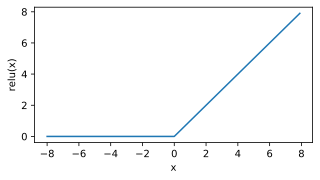

In [2]:
x = tf.Variable(tf.range(-8, 8, 0.1), dtype=tf.float32)
y = tf.nn.relu(x)
xyplot(x, y , 'relu')

显然，当输入为负数时，ReLU函数的导数为0；当输入为正数时，ReLU函数的导数为1。尽管输入为0时ReLU函数不可导，但是我们可以取此处的导数为0。下面绘制ReLU函数的导数。

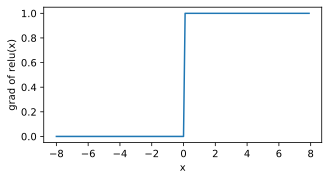

In [3]:
with tf.GradientTape() as t:
    t.watch(x)
    y = tf.nn.relu(x)
dy_dx = t.gradient(y, x)
xyplot(x, dy_dx, 'grad of relu')

#### Sigmoid函数
sigmoid函数可以将元素的值变换到0和1之间：


$$
\text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$




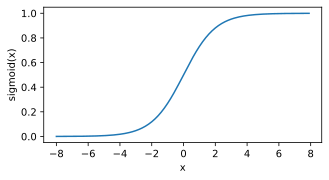

In [4]:
y = tf.nn.sigmoid(x)
xyplot(x, y , 'sigmoid')

依据链式法则，sigmoid函数的导数


$$
\text{sigmoid}'(x) = \text{sigmoid}(x)\left(1-\text{sigmoid}(x)\right).
$$


下面绘制了sigmoid函数的导数。当输入为0时，sigmoid函数的导数达到最大值0.25；当输入越偏离0时，sigmoid函数的导数越接近0。

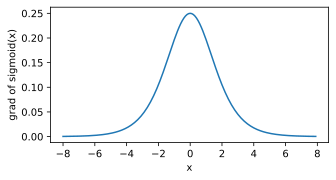

In [5]:
with tf.GradientTape() as t:
    t.watch(x)
    y = tf.nn.sigmoid(x)
dy_dx = t.gradient(y, x)
xyplot(x, dy_dx, 'grad of sigmoid')

#### tanh函数
tanh（双曲正切）函数可以将元素的值变换到-1和1之间：


$$
\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.
$$


我们接着绘制tanh函数。当输入接近0时，tanh函数接近线性变换。虽然该函数的形状和sigmoid函数的形状很像，但tanh函数在坐标系的原点上对称。

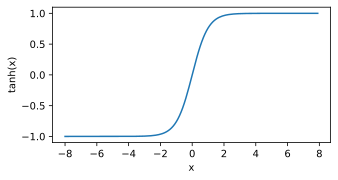

In [6]:
y = tf.nn.tanh(x)
xyplot(x, y, 'tanh')

依据链式法则，tanh函数的导数


$$
\text{tanh}'(x) = 1 - \text{tanh}^2(x).
$$


下面绘制了tanh函数的导数。当输入为0时，tanh函数的导数达到最大值1；当输入越偏离0时，tanh函数的导数越接近0。

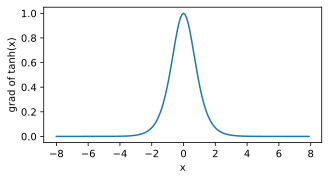

In [7]:
with tf.GradientTape() as t:
    t.watch(x)
    y = tf.nn.tanh(x)
dy_dx = t.gradient(y, x)
xyplot(x, dy_dx, 'grad of tanh')

### 关于激活函数的选择

ReLu函数是一个通用的激活函数，目前在大多数情况下使用。但是，ReLU函数只能在隐藏层中使用。

用于分类器时，sigmoid函数及其组合通常效果更好。由于梯度消失问题，有时要避免使用sigmoid和tanh函数。  

在神经网络层数较多的时候，最好使用ReLu函数，ReLu函数比较简单计算量少，而sigmoid和tanh函数计算量大很多。

在选择激活函数的时候可以先选用ReLu函数如果效果不理想可以尝试其他激活函数。


正是因为模拟人脑的生物神经网络的方法。在2001年有研究表明生物脑的神经元工作具有稀疏性，这样可以节约尽可能多的能量，据研究，只有大约1%-4%的神经元被激活参与，绝大多数情况下，神经元是处于抑制状态的，因此ReLu函数反而是更加优秀的近似生物激活函数。
所以第一个问题，抑制现象是必须发生的，这样能更好的拟合特征。
那么自然也引申出了第二个问题，为什么sigmoid函数这类函数不行？
1. 中间部分梯度值过小（最大只有0.25）因此即使在中间部分也没有办法明显的激活，反而会在多层中失活，表现非常不好。(梯度更易消失，反向传播时不断减小)

2. 指数运算在计算中过于复杂，不利于运算，反而ReLu函数用最简单的梯度

在第二条解决之后，我们来看看ReLu函数所遇到的问题，

1. 在负向部分完全失活，如果选择的超参数不好等情况，可能会出现过多神经元失活，从而整个网络死亡。
2. ReLu函数不是zero-centered，即激活函数输出的总是非负值，而gradient也是非负值，在back propagate情况下总会得到与输入x相同的结果，同正或者同负，因此收敛会显著受到影响，一些要减小的参数和要增加的参数会受到捆绑限制。

这两个问题的解决方法分别是

1. 如果出现神经元失活的情况，可以选择调整超参数或者换成Leaky ReLu 但是，没有证据证明任何情况下都是Leaky-ReLu好
2. 针对非zero-centered情况，可以选择用minibatch gradient decent 通过batch里面的正负调整，或者使用ELU(Exponential Linear Units)但是同样具有计算量过大的情况，同样没有证据ELU总是优于ReLU。

所以绝大多数情况下建议使用ReLu。

### 多层感知机
多层感知机就是含有至少一个隐藏层的由全连接层组成的神经网络，且每个隐藏层的输出通过激活函数进行变换。多层感知机的层数和各隐藏层中隐藏单元个数都是超参数。以单隐藏层为例并沿用本节之前定义的符号，多层感知机按以下方式计算输出：


$$
 \begin{aligned} \boldsymbol{H} &= \phi(\boldsymbol{X} \boldsymbol{W}_h + \boldsymbol{b}_h),\\ \boldsymbol{O} &= \boldsymbol{H} \boldsymbol{W}_o + \boldsymbol{b}_o, \end{aligned} 
$$


其中$\phi$表示激活函数。

## 多层感知机从零开始的实现

In [8]:
import tensorflow as tf
import numpy as np
import sys
print(tf.__version__)

2.1.0


### 获取训练集

In [60]:
from tensorflow.keras.datasets import fashion_mnist

batch_size=256
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = tf.cast(x_train, tf.float32) / 255 #在进行矩阵相乘时需要float型，故强制类型转换为float型
x_test = tf.cast(x_test,tf.float32) / 255 #在进行矩阵相乘时需要float型，故强制类型转换为float型
train_iter = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_iter = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

### 定义模型参数

Fashion-MNIST数据集中图像形状为 $28 \times 28$，类别数为10。本节中我们依然使用长度为 $28 \times 28 = 784$ 的向量表示每一张图像。因此，输入个数为784，输出个数为10。实验中，我们设超参数隐藏单元个数为256。

In [59]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = tf.Variable(tf.random.normal(shape=(num_inputs, num_hiddens),mean=0, stddev=0.01, dtype=tf.float32))
b1 = tf.Variable(tf.zeros(num_hiddens, dtype=tf.float32))
W2 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_outputs),mean=0, stddev=0.01, dtype=tf.float32))
b2 = tf.Variable(tf.random.normal([num_outputs], stddev=0.1))

### 定义激活函数

In [11]:
def relu(x):
    return tf.math.maximum(x, 0)

### 定义网络

In [12]:
def net(X):
    X = tf.reshape(X, shape=[-1, num_inputs])
    h = relu(tf.matmul(X, W1) + b1)
    return tf.math.softmax(tf.matmul(h, W2) + b2)

### 定义损失函数

In [54]:
 # SparseCategoricalCrossentropy类,先声明类，再调用方法
#  默认使用 reduction SUM_over_batch_size已经除以了 batch_size,所以sgd 不需要再除以 batch_size 了
cross_entropy = tf.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

In [62]:
def loss(y_hat, y_true):
    # 交叉熵损失
    # sparse_categorical_crossentropy 是一个方法，没有进行 sum， 相当于 SparseCategoricalCrossentropy类 参数 reduction=None
    return tf.losses.sparse_categorical_crossentropy(y_true, y_hat)

In [33]:
help(tf.losses.sparse_categorical_crossentropy)

Help on function sparse_categorical_crossentropy in module tensorflow.python.keras.losses:

sparse_categorical_crossentropy(y_true, y_pred, from_logits=False, axis=-1)



### 训练

In [58]:
def sgd(params, lr, batch_size, grads):
    """
    Mini-batch stochastic gradient descent.
    lr: 步长
    """
    # 对每一个参数求梯度，并更新
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i] / batch_size)

In [19]:
# 描述,对于tensorflow2中，比较的双方必须类型都是int型，所以要将输出和标签都转为int型
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for _, (X, y) in enumerate(data_iter):
        y = tf.cast(y,dtype=tf.int64)
        acc_sum += np.sum(tf.cast(tf.argmax(net(X), axis=1), dtype=tf.int64) == y)
        n += y.shape[0]
    return acc_sum / n

In [63]:
# 迭代周期，学习率
num_epochs, lr = 5, 0.5
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                # print(y_hat.dtype, y_hat.shape, y.dtype,y.shape)
                # l = loss(y, y_hat)
                # print(l.dtype,l.shape)
                l = tf.reduce_sum(loss(y_hat, y))
                # print(l.dtype,l.shape)
                
            grads = tape.gradient(l, params)
            # tf.keras.optimizers.SGD 直接使用是随机梯度下降 theta(t+1) = theta(t) - learning_rate * gradient
            sgd(params, lr, batch_size, grads)
                
            y = tf.cast(y, dtype=tf.float32)
            train_l_sum += l.numpy()
            train_acc_sum += tf.reduce_sum(tf.cast(tf.argmax(y_hat, axis=1) == tf.cast(y, dtype=tf.int64), dtype=tf.int64)).numpy()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'% (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

params = [W1, b1, W2, b2]
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.8198, train acc 0.694, test acc 0.799
epoch 2, loss 0.4863, train acc 0.819, test acc 0.832
epoch 3, loss 0.4235, train acc 0.843, test acc 0.845
epoch 4, loss 0.3911, train acc 0.855, test acc 0.853
epoch 5, loss 0.3701, train acc 0.863, test acc 0.861


## 多层感知机 tensorflow 2.0 简洁实现

In [64]:
import tensorflow as tf
from tensorflow import keras
import sys
fashion_mnist = keras.datasets.fashion_mnist

### 初始化模型和各个参数

In [65]:
# 与 softmax 不同，添加了隐藏层，隐藏单元 256个
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28)),
                                   tf.keras.layers.Dense(256, activation='relu'),
                                   tf.keras.layers.Dense(10, activation='softmax')])

### 训练

In [66]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.5), 
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=256, 
          validation_data=(x_test, y_test),
         validation_freq=1)


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 25us/sample - loss: 0.8312 - accuracy: 0.7086 - val_loss: 0.5914 - val_accuracy: 0.7806
Epoch 2/5
60000/60000 [==============================] - 1s 12us/sample - loss: 0.4867 - accuracy: 0.8203 - val_loss: 0.4705 - val_accuracy: 0.8240
Epoch 3/5
60000/60000 [==============================] - 1s 12us/sample - loss: 0.4150 - accuracy: 0.8478 - val_loss: 0.5270 - val_accuracy: 0.8078
Epoch 4/5
60000/60000 [==============================] - 1s 11us/sample - loss: 0.3882 - accuracy: 0.8564 - val_loss: 0.4554 - val_accuracy: 0.8328
Epoch 5/5
60000/60000 [==============================] - 1s 11us/sample - loss: 0.3669 - accuracy: 0.8644 - val_loss: 0.4590 - val_accuracy: 0.8317
